In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

#Remove data for these address
193 Aldi Blvd, Mt Juliet, TN: 36.0666667, -86.4347222
137 Eady Road – Bell Buckle, TN: 35.5883333, -86.4438888
5754 Fish Hatchery Road – Russellville, TN: 36.1950, -83.174722

### Get data from CSV files, get columns into correct dtypes, drop unnecessary columns and rows and merge

In [415]:
vdd_data = pd.read_csv('data/VehicleDiagnosticOnboardData.csv')
faults = pd.read_csv('data/J1939Faults.csv')
#service_fault_codes = pd.read_csv('data/Service Fault Codes_1_0_0_167.csv')

/Users/sbussa/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [416]:
#pivot the data from vdd for each fault id so that we get call codes in one row
vdd_pivot = vdd_data.pivot(index = 'FaultId',columns = 'Name',values = 'Value')
vdd_pivot=vdd_pivot.reset_index()

In [417]:
#from faults, drop the unnecessary columns and save it into faults_clean
faults_clean=faults
faults_clean=faults_clean.drop(['actionDescription','ecuSoftwareVersion','ecuSerialNumber','ecuModel','ecuSource','faultValue','MCTNumber','LocationTimeStamp'],axis=1).reset_index()

In [413]:
vdd_pivot.LampStatus.value_counts()

In [418]:
#start preparing the final data set (df) by merging faults_clean and vdd_pivot
df=faults_clean.merge(right = vdd_pivot, left_on = 'RecordID',right_on = 'FaultId')

In [420]:
df.shape

(1187335, 38)

In [421]:
#Getting the columns into right datatypes in the final dataset
ls = ['DistanceLtd','EngineCoolantTemperature','EngineOilPressure','EngineOilTemperature','EngineRpm','EngineTimeLtd'
     ,'FuelLevel','FuelLtd','FuelRate','FuelTemperature','IntakeManifoldTemperature','Speed','SwitchedBatteryVoltage',
      'Throttle','TurboBoostPressure','AcceleratorPedal','BarometricPressure']

for x in ls:
    df[x]=df[x].str.replace(',', '')
    
df.iloc[:,17:29] = df.iloc[:,17:29].apply(pd.to_numeric)
df.iloc[:,30:32]=df.iloc[:,30:32].apply(pd.to_numeric)
df.iloc[:,33:]=df.iloc[:,33:].apply(pd.to_numeric)
df['EventTimeStamp'] = df.EventTimeStamp.apply(pd.to_datetime)
df['AcceleratorPedal']=df.AcceleratorPedal.apply(pd.to_numeric)
df['BarometricPressure'] = df['BarometricPressure'].apply(pd.to_numeric)


In [422]:
#Drop unnecessary rows

#drop inactive rows
df.drop(df[df['active'] == 0].index, inplace = True)

#drop incorrect Equipment ID rows
df.drop(df[df.EquipmentID.str.len()>4].index,inplace =True)
#df['EquipmentID'] = df['EquipmentID'].apply(pd.to_numeric)

#drop locations which are in 1 mile radius of these  3 locaitons.
lat_min1 = 36.0566667
lat_max1 =36.0766667
lng_min1 = -86.4447222
lng_max1 = -86.4247222
df.drop(df[(df['Latitude'] > lat_min1)&(df['Latitude'] <lat_max1)&(df['Longitude'] >lng_min1)&(df['Longitude'] <lng_max1)].index, inplace=True)  

lat_min2 = 35.5783333
lat_max2 =35.5983333
lng_min2 = -86.4538888
lng_max2 = -86.4338888
df.drop(df[(df['Latitude'] > lat_min2)&(df['Latitude'] <lat_max2)&(df['Longitude'] >lng_min2)&(df['Longitude'] <lng_max2)].index, inplace=True)   

lat_min3 = 36.1850
lat_max3 =36.2050
lng_min3 = -83.184722
lng_max3 = -83.164722
df.drop(df[(df['Latitude'] > lat_min3)&(df['Latitude'] <lat_max3)&(df['Longitude'] >lng_min3)&(df['Longitude'] <lng_max3)].index, inplace=True)

In [423]:
#convert the boolean columns into right datatypes and populate them with 1's and 0's
ls = ['CruiseControlActive','IgnStatus','ParkingBrake','active']

for x in ls:
    df[x]=df[x].astype('bool')

df['active']=df.active.astype(int)
df['CruiseControlActive']=df.CruiseControlActive.astype(int)
df['ParkingBrake']=df.ParkingBrake.astype(int)
df['IgnStatus'] =df.IgnStatus.astype(int)
df['LampStatus'] = df.LampStatus.astype('category')

# Start EDA

In [424]:
d_rate=df[df['spn']==5246]
#d_rate_all=df[df['spn'].isin(['5246','1569'])]

d_rate_data=d_rate.groupby('EquipmentID').RecordID.count().reset_index(name = 'num_of_d_rate')

In [425]:
len(d_rate.EquipmentID.unique().tolist())#197 trucks broke down

197

In [426]:
d_rate_data.num_of_d_rate.sum()

497

In [427]:
d_rate_data['avg_no_of_derates_per_truck']=d_rate_data.num_of_d_rate.sum()/len(d_rate.EquipmentID.unique().tolist())

In [432]:
top_break_down_equipments=d_rate_data[d_rate_data.num_of_d_rate > 5]

In [466]:
 df[df['spn']==5246].shape--497

(497, 75)

In [443]:
top_break_down_equipments.sort_values(by = 'num_of_d_rate', ascending = False )

,EquipmentID,num_of_d_rate,avg_no_of_derates_per_truck
38,1524,31,2.522843
43,1535,23,2.522843
39,1525,15,2.522843
45,1539,14,2.522843
3,305,13,2.522843
33,1490,11,2.522843
28,1453,11,2.522843
47,1547,10,2.522843
37,1521,9,2.522843
42,1534,9,2.522843


Text(0.5, 1.0, 'Vehicles with most full derates')

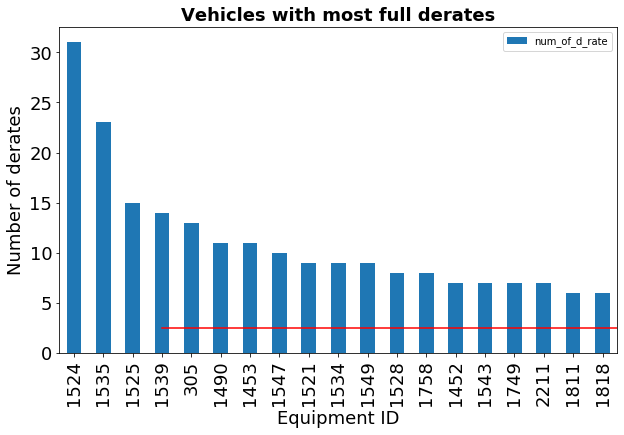

In [458]:
fig, ax = plt.subplots(figsize=(10, 6))
top_break_down_equipments.avg_no_of_derates_per_truck.plot(kind = 'line',secondary_y=False,color = 'r',ax=ax)
top_break_down_equipments.sort_values(by = 'num_of_d_rate', ascending = False )\
                                            .plot(kind = 'bar',x='EquipmentID',y='num_of_d_rate',ax=ax)
plt.xlabel("Equipment ID", fontsize = 18)
plt.ylabel('Number of derates', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
#ax.get_legend().remove()
plt.title('Vehicles with most full derates', fontweight = 'bold', fontsize = 18)
#top_break_down_equipments.avg_no_of_derates_per_truck.head(19).plot(kind = 'line',ax=ax)


### More cleaning of data like filling NaN's

In [459]:
#columns with nans into a list (find which columns has nan values)
col_with_nans=df.columns[df.isna().any()].tolist()

#select only the columns whose data type is a number and has Nan's
df_cols_nan_numeric= df[col_with_nans].select_dtypes(include=np.number)

#in the original dataframe, fill the nan values with mean values where we have nans for numeric columns.
df[df_cols_nan_numeric.columns]=df[df_cols_nan_numeric.columns].fillna(df[df_cols_nan_numeric.columns].mean())

#Fill the missing values for object data type columns.
df.eventDescription=df.eventDescription.fillna("MissingDesc")
df.ecuMake = df.ecuMake.fillna("MissingMake")

#df.isna().sum()

#df.shape (547678, 38)
#df[df['spn']==5246].shape (497, 38)

In [460]:
df['Dates'] = pd.to_datetime(df['EventTimeStamp'], format='%Y:%M:%D').dt.date
df['Hours'] = pd.to_datetime(df['EventTimeStamp'], format='%Y:%M:%D').dt.time
df['Dates'] = df.Dates.apply(pd.to_datetime)

In [461]:
#We needed to flatten the lampstatus as its a categorical datatype. Use get dummies with prefix and the add it to df
lamp_status_dummies = pd.get_dummies(df.LampStatus,prefix='ls')
df=pd.concat([df,lamp_status_dummies],axis=1)

#drop unnecessary index column from df
#df.drop('index',axis=1,inplace = True)

In [462]:
lamp_status_dummies.head()

,ls_0,ls_2,ls_9,ls_11,ls_255,ls_511,ls_544,ls_617,ls_1023,ls_1279,ls_2035,ls_2047,ls_4351,ls_5119,ls_5375,ls_6143,ls_11801,ls_16639,ls_16895,ls_17407,ls_17663,ls_18419,ls_18431,ls_20735,ls_21503,ls_22515,ls_22527,ls_28436,ls_50175,ls_50431,ls_51199,ls_55295,ls_62463,ls_63487,ls_65535
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [463]:
df.shape

(547678, 75)

## Save the clean dataframe to disk using pickle

In [464]:
#Save the dataFrame to the disk so that it can be read easily
import pickle

#save the df to file
with open('data/clean_bigGExpress_data.pkl','wb') as file:
    pickle.dump(df,file=file)


In [8]:
#with open('data/clean_bigGExpress_data.pkl','rb') as file:
 #   df=pickle.load(file=file)

#lets try to read the file
with open('data/clean_bigGExpress_data.pkl','rb') as file:
    df2 = pickle.load(file)

### EDA for single truck which had more breakdowns. (Truck  #1524)

In [ ]:
#EquipmentId =df[df['spn']==5246]
#unique_Equipment_5246 = EquipmentId['EquipmentID'].unique().tolist()

In [138]:
#time series data
time_series_df = df
time_series_df=time_series_df.set_index('EventTimeStamp')

In [468]:
Equip_1524=df[df['EquipmentID']==1524].sort_values(by = 'EventTimeStamp')

truck_1524_data=Equip_1524[Equip_1524['EquipmentID']==1524] 
truck_1524_data= truck_1524_data.reset_index()

truck_1524_data['Dates'] = pd.to_datetime(truck_1524_data['EventTimeStamp'], format='%Y:%M:%D').dt.date
truck_1524_data['Hours'] = pd.to_datetime(truck_1524_data['EventTimeStamp'], format='%Y:%M:%D').dt.time

In [469]:
t=df[['EquipmentID','EventTimeStamp','Dates','Hours','spn','fmi']].sort_values(by = 'EventTimeStamp')

In [ ]:
#faults=df[['EquipmentID','EventTimeStamp','Dates','Hours','spn','fmi']].sort_values(by = 'EventTimeStamp')

In [471]:
single_truck_data =t.groupby(['EquipmentID','Dates','spn'])['EquipmentID','Dates','spn','EventTimeStamp'].min().sort_values(by='EventTimeStamp')
#single_truck_data = single_truck_data.reset_index()

In [479]:
truck_1524_data.groupby(['EquipmentID','Dates','spn'])['EquipmentID','Dates','spn','EventTimeStamp'].min().sort_values(by='EventTimeStamp').reset_index()


,EquipmentID,Dates,spn,EventTimeStamp
0,1524,2015-12-29,111,2015-12-29 15:51:38
1,1524,2016-01-04,111,2016-01-04 12:07:29
2,1524,2016-01-04,627,2016-01-04 12:07:29
3,1524,2016-01-06,5394,2016-01-06 13:27:28
4,1524,2016-01-06,4094,2016-01-06 14:07:24
5,1524,2016-01-06,5246,2016-01-06 14:07:24
6,1524,2016-01-07,791,2016-01-07 09:09:19
7,1524,2016-01-07,792,2016-01-07 09:09:19
8,1524,2016-01-07,793,2016-01-07 09:09:19
9,1524,2016-01-07,794,2016-01-07 09:09:19


In [ ]:
#EquipmentId =df[df['spn']==5246]
#unique_Equipment_5246 = EquipmentId['EquipmentID'].unique().tolist()

In [483]:
#make a list of distinct trucks
trucks_with_drates = df['EquipmentID'].unique().tolist()

In [488]:
df.head()

,index,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,Dates,Hours,ls_0,ls_2,ls_9,ls_11,ls_255,ls_511,ls_544,ls_617,ls_1023,ls_1279,ls_2035,ls_2047,ls_4351,ls_5119,ls_5375,ls_6143,ls_11801,ls_16639,ls_16895,ls_17407,ls_17663,ls_18419,ls_18431,ls_20735,ls_21503,ls_22515,ls_22527,ls_28436,ls_50175,ls_50431,ls_51199,ls_55295,ls_62463,ls_63487,ls_65535
0,0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,111,17,1,2,1439,38.857638,-84.626851,1,0.000000,14.210000,1,66.486720,423178.70000,100.40000,11.00000,0.000000,96.743750,0.000000,1632.200000,43.200000,1.230091e+04,0.000000,36.901025,1,78.800000,1023,1,9199.322087,0.000000,3276.750000,70.11936,0.000000,2015-02-21,10:47:13,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,990360,2015-02-21 11:34:34,MissingDesc,unknown,629,12,1,127,1439,38.857638,-84.626851,2,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:34:34,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,1807,2,1,127,1369,41.421018,-87.767361,4,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:35:33,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,6,990431,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,CMMNS,111,17,1,1,1417,33.043564,-96.179722,6,48.000000,14.427500,1,64.622600,470381.40000,181.40000,30.00000,38.280000,196.531300,1514.500000,9480.000000,44.000000,7.034981e+04,4.583399,36.901025,1,111.200000,1023,1,9199.322087,13.602200,3276.750000,70.11936,6.670000,2015-02-21,11:40:22,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,7,990439,2015-02-21 11:40:52,Low (Severity Low) Engine Coolant Level,unknown,111,17,1,2,1597,36.902916,-86.436481,7,82.800000,14.282500,1,64.622600,278736.70000,188.60000,80.00000,39.440000,210.031300,1711.375000,6292.200000,64.800000,4.096107e+04,14.291750,36.901025,1,78.800000,1023,1,9199.322087,41.534780,3276.750000,70.11936,20.590000,2015-02-21,11:40:52,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [492]:
faults.head()

,EquipmentID,Dates,spn,EventTimeStamp
0,2015,2000-03-18,96,2000-03-18 19:14:10
1,2015,2000-03-18,829,2000-03-18 19:14:10
2,1849,2000-03-19,792,2000-03-19 03:58:23
3,2283,2000-03-19,37,2000-03-19 07:32:53
4,2034,2000-03-19,96,2000-03-19 08:40:03


In [ ]:
faults=df.groupby(['EquipmentID','Dates','spn'])['EquipmentID','Dates','spn','EventTimeStamp'].min().sort_values(by='EventTimeStamp') 
faults=faults.reset_index()

In [493]:
def get_my_fault_codes(trucks_with_drates):
    
    df=faults
   
    list_of_fault_codes = []
    truck = trucks_with_drates
    my_list =[]
   
    truck_list=[]
    dates_list=[]
   

    for t in truck:
        EquipmentId =df[df['EquipmentID']==t]
        unique_dates_for_equip = EquipmentId['Dates'].unique()
        unique_dates_for_equip = pd.DataFrame(unique_dates_for_equip)
       
       
       
        for d in unique_dates_for_equip[0]:
               
                date_df = EquipmentId[EquipmentId['Dates']==d]
                unique_spn_for_equip_date = date_df['spn'].unique()
                unique_spn_for_equip_date = pd.DataFrame(unique_spn_for_equip_date)
               
               
                list_of_fault_codes = []
                truck_list.append(t)
                dates_list.append(d)
               
                for s in unique_spn_for_equip_date[0]:
                   
                   
                    if s != 5246:
                        list_of_fault_codes.append(s)
                    else:
                        list_of_fault_codes.append(-99)
                        break
                my_list.append(list_of_fault_codes)

 
    faults_final = pd.DataFrame({'truck': truck_list,'dates':dates_list,'faults':my_list})
   
    return faults_final

In [494]:
#unique_Equipment_5246 = []
#unique_Equipment_5246.append(1524)

x=get_my_fault_codes(trucks_with_drates)
x

,truck,dates,faults
0,1439,2015-02-21,"[111, 629]"
1,1439,2015-02-22,"[629, 111, 50353]"
2,1439,2015-02-23,"[629, 50353]"
3,1439,2015-02-24,"[111, 629]"
4,1439,2015-02-25,"[111, 629]"
5,1439,2015-02-26,[629]
6,1439,2015-04-10,"[629, 111]"
7,1439,2015-04-11,"[629, 111]"
8,1439,2015-04-13,"[111, 629]"
9,1439,2015-04-14,[629]


There are 197 trucks which has fault codes of 5246

In [ ]:
#faults_final = pd.get_dummies(x.faults.apply(pd.Series).stack()).sum(level=0)

In [495]:
x.shape##(138410, 3)

(138410, 3)

In [496]:
#use get_dummies  to flatten the list of faults and add it back to original dataframe

faults_final = pd.get_dummies(x.faults.apply(pd.Series).stack()).sum(level=0)
faults_final = pd.concat([x,faults_final],axis=1)

In [147]:
faults_final.shape#(138410, 421)

(138410, 421)

In [497]:
#merge the original df dataframe to the flattened faults dataframe
bigGExpress=df.merge(right = faults_final, left_on = ['EquipmentID','Dates'],right_on = ['truck','dates'],how='outer')

In [498]:
bigGExpress.shape ##(547678, 495)

(547678, 496)

In [499]:
#drop the columns not needed as filtering is done and then group by truck and date

not_needed_columns = ['RecordID','ESS_Id','index','EventTimeStamp','Hours',\
                      'eventDescription','ecuMake','Latitude','Longitude','active',\
                      'faults','dates','activeTransitionCount','spn','fmi','FaultId','truck']


bigGExpress_final = bigGExpress.drop(not_needed_columns, axis=1)
bigGExpress_final=bigGExpress_final.groupby(['EquipmentID','Dates']).mean().reset_index()

In [57]:
#bigGExpress_final=bigGExpress_final.groupby(['EquipmentID','Dates']).mean().reset_index()

In [500]:
bigGExpress_final.shape##(138410, 444)#(138410, 478)

(138410, 478)

In [155]:
bigGExpress_final.head()

,EquipmentID,Dates,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,ls_0,ls_2,ls_9,ls_11,ls_255,ls_511,ls_544,ls_617,ls_1023,ls_1279,ls_2035,ls_2047,ls_4351,ls_5119,ls_5375,ls_6143,ls_11801,ls_16639,ls_16895,ls_17407,ls_17663,ls_18419,ls_18431,ls_20735,ls_21503,...,17590.0,25780.0,29902.0,32000.0,32894.0,35527.0,36017.0,37265.0,39093.0,42190.0,43088.0,46262.0,47284.0,50353.0,51923.0,53958.0,54478.0,56503.0,65287.0,65302.0,65303.0,65535.0,76339.0,78132.0,88121.0,114863.0,139296.0,153931.0,196608.0,335040.0,520200.0,520201.0,520203.0,520271.0,520273.0,520274.0,520298.0,520302.0,520321.0,520330.0,520413.0,520953.0,521032.0,523530.0,523531.0,523543.0,524033.0,524037.0,524071.0,524287.0
0,301,2015-05-11,14.4,13.9200,1,0.0,120841.7,185.0,18.0,55.10,193.6062,1145.75,2372.75,76.4,17070.798000,2.760607,134.6,1,154.4,1,9199.322087,4.475814,3276.75,14.4,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,301,2015-05-13,89.6,14.4275,1,0.0,121687.1,186.8,38.0,52.78,217.1750,1257.50,2388.15,72.4,17193.373832,6.326941,100.4,1,120.2,1,9199.322087,64.637170,3276.75,89.6,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,301,2015-05-18,0.0,14.3550,1,0.0,123057.1,185.0,0.0,55.68,213.9688,1230.25,2413.65,50.8,17376.312978,0.000000,120.2,1,118.4,1,9199.322087,63.525490,3276.75,0.0,20.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,301,2015-05-21,12.0,14.5725,1,0.0,124496.5,183.2,14.0,51.62,196.7000,1115.50,2443.50,41.2,17577.347910,2.311513,109.4,1,107.6,1,9199.322087,4.364162,3276.75,12.0,1.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,301,2015-05-28,67.2,13.9200,1,0.0,125989.2,183.2,68.0,51.62,215.2063,1257.50,2475.90,62.4,17776.401551,11.465100,123.8,1,129.2,1,9199.322087,64.836200,3276.75,68.0,20.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save the final data set to disk by pickling

In [501]:
#save the df to file
with open('data/bigGExpress_final.pkl','wb') as file:
       pickle.dump(bigGExpress_final,file=file)

In [44]:
#with open('data/bigGExpress_final.pkl','rb') as file:
    bigGExpress_final_test=pickle.load(file)

In [254]:
 bigGExpress_final.head()

,EquipmentID,Dates,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,ls_0,ls_2,ls_9,ls_11,ls_255,ls_511,ls_544,ls_617,ls_1023,ls_1279,ls_2035,ls_2047,ls_4351,ls_5119,ls_5375,ls_6143,ls_11801,ls_16639,ls_16895,ls_17407,ls_17663,ls_18419,ls_18431,ls_20735,ls_21503,...,17590.0,25780.0,29902.0,32000.0,32894.0,35527.0,36017.0,37265.0,39093.0,42190.0,43088.0,46262.0,47284.0,50353.0,51923.0,53958.0,54478.0,56503.0,65287.0,65302.0,65303.0,65535.0,76339.0,78132.0,88121.0,114863.0,139296.0,153931.0,196608.0,335040.0,520200.0,520201.0,520203.0,520271.0,520273.0,520274.0,520298.0,520302.0,520321.0,520330.0,520413.0,520953.0,521032.0,523530.0,523531.0,523543.0,524033.0,524037.0,524071.0,524287.0
0,301,2015-05-11,14.4,13.9200,1,0.0,120841.7,185.0,18.0,55.10,193.6062,1145.75,2372.75,76.4,17070.798000,2.760607,134.6,1,154.4,1,9199.322087,4.475814,3276.75,14.4,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,301,2015-05-13,89.6,14.4275,1,0.0,121687.1,186.8,38.0,52.78,217.1750,1257.50,2388.15,72.4,17193.373832,6.326941,100.4,1,120.2,1,9199.322087,64.637170,3276.75,89.6,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,301,2015-05-18,0.0,14.3550,1,0.0,123057.1,185.0,0.0,55.68,213.9688,1230.25,2413.65,50.8,17376.312978,0.000000,120.2,1,118.4,1,9199.322087,63.525490,3276.75,0.0,20.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,301,2015-05-21,12.0,14.5725,1,0.0,124496.5,183.2,14.0,51.62,196.7000,1115.50,2443.50,41.2,17577.347910,2.311513,109.4,1,107.6,1,9199.322087,4.364162,3276.75,12.0,1.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,301,2015-05-28,67.2,13.9200,1,0.0,125989.2,183.2,68.0,51.62,215.2063,1257.50,2475.90,62.4,17776.401551,11.465100,123.8,1,129.2,1,9199.322087,64.836200,3276.75,68.0,20.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [502]:
g = bigGExpress_final[-99]
percent = pd.concat([g.value_counts(),              
g.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))

percent.percentage = percent['percentage'].round(2)
percent

,counts,percentage
0.0,138025,99.72
1.0,385,0.28


Text(0.5, 1.0, 'Percentage of derates')

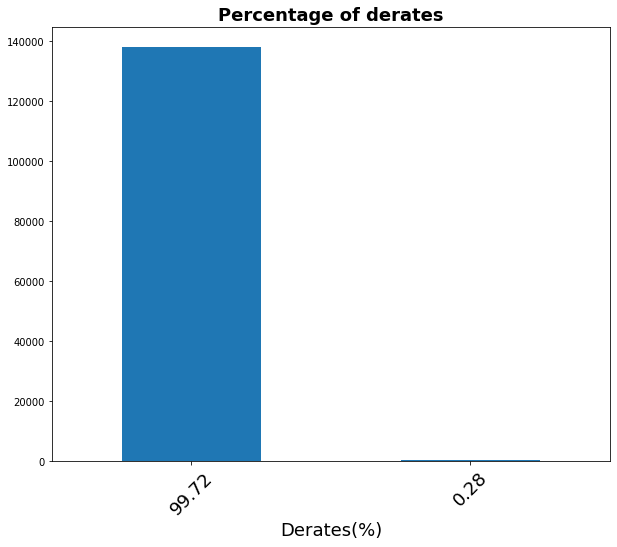

In [513]:
fig,ax = plt.subplots(figsize = (10,8))
percent.plot(kind= 'bar',x = 'percentage',ax=ax)
plt.xlabel('Derates(%)''', fontsize = 18)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 18,rotation = 45)
ax.get_legend().remove()

plt.title('Percentage of derates', fontweight = 'bold', fontsize = 18)

## Algorithms

In [514]:
import sklearn
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split

In [162]:
remove_from_X = ['EquipmentID','Dates',-99]
y=bigGExpress_final[-99]
X=bigGExpress_final.drop(remove_from_X,axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42, stratify = y)

In [ ]:
#Remove 4094 fault. code

## Lasso Regression

In [163]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001,normalize =True)
lasso_coef = lasso.fit(X_train,y_train)
lasso_coef = lasso_coef.coef_
print (lasso_coef)

[-0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.
  0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0.  0. -0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.
 -0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0

#features
df_columns=X_train.columns.values
important_features=pd.concat([pd.DataFrame(df_columns), pd.DataFrame(lasso_coef)], axis=1)
important_features.columns = ['features','coefficients']
important_features.sort_values(by= 'coefficients')

## Logistic Regression with L1 Regularization

In [515]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

In [516]:
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.33, random_state=42)

In [517]:
clf = LogisticRegression(penalty ='l1',C=10,solver = 'saga',max_iter=100)
clf.fit(X_train,y_train)

#c is the inverse of alpha from lasso. The smaller the value, we are penalizing it more.

/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [518]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

[[45535    27]
 [   95    19]]


In [519]:
#new scores with lamp Status Dummeized
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45562
         1.0       0.41      0.17      0.24       114

    accuracy                           1.00     45676
   macro avg       0.71      0.58      0.62     45676
weighted avg       1.00      1.00      1.00     45676



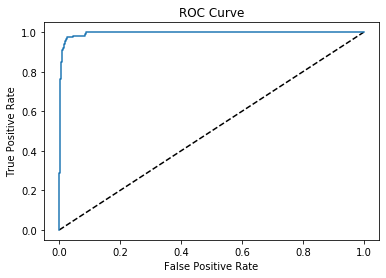

In [172]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label ='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [173]:
# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf, X,y,cv=5,scoring = 'roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9949833155823142


/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


AUC scores computed using 5-fold cross-validation: [0.38223383 0.26884787 0.2662133  0.26127584 0.44167182]


/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [520]:
#find important features

df_columns=X.columns.values
important_features=pd.concat([pd.DataFrame(df_columns), pd.DataFrame(clf.coef_[0])], axis=1)
important_features.columns = ['features','coefficients']
important_features=important_features.sort_values(by= 'coefficients',ascending = False)
important_features

,features,coefficients
49,ls_22527,0.137179
248,1569,0.058457
14,FuelTemperature,0.050930
376,5394,0.047541
43,ls_17663,0.042537
66,74,0.025093
383,5485,0.020370
293,3362,0.020077
94,158,0.018281
38,ls_6143,0.017591


In [176]:
important_features.tail(20)

,features,coefficients
312,3605,-0.007876
76,96,-0.007966
42,ls_17407,-0.008067
223,1172,-0.008223
1,BarometricPressure,-0.008876
101,175,-0.009285
382,5443,-0.009308
87,111,-0.009535
370,5117,-0.009662
364,5111,-0.010128


In [177]:
clf.intercept_

array([-2.94810721])

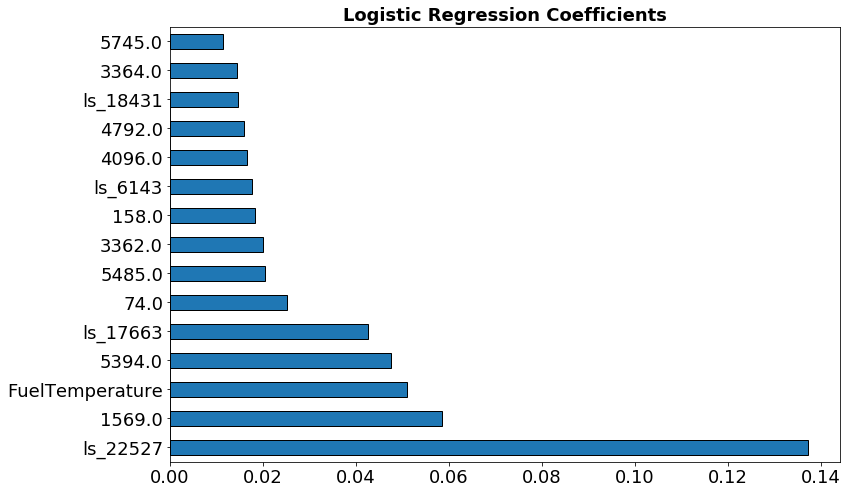

In [521]:
fig, ax = plt.subplots(figsize=(12, 8))
important_features.head(15).plot.barh(x = 'features', y = 'coefficients', ax = ax, edgecolor = 'black')
plt.vlines(x = 0, ymin = 0, ymax = 12)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('')
plt.title('Logistic Regression Coefficients', fontweight = 'bold', fontsize = 18)
ax.get_legend().remove();

In [179]:
#save the clf(classifier) to file
with open('data/logistic_model.pkl','wb') as file:
    pickle.dump(clf,file=file)

In [30]:
with open('data/logistic_model.pkl','rb') as file:
    clf=pickle.load(file)

# Remove 4094 and see for features

In [ ]:
bigGExpress_final

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data = bigGExpress_final, x = 'x', y = 'y', hue = 'label', ax = ax);

In [280]:
remove_from_X = ['EquipmentID','Dates',-99,4094]
y=bigGExpress_final[-99]
X=bigGExpress_final.drop(remove_from_X,axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42, stratify = y)

In [281]:
clf = LogisticRegression(penalty ='l1',C=10,solver = 'saga',max_iter=100)
clf.fit(X_train,y_train)

/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [282]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[27605     0]
 [   77     0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     27605
         1.0       0.00      0.00      0.00        77

    accuracy                           1.00     27682
   macro avg       0.50      0.50      0.50     27682
weighted avg       0.99      1.00      1.00     27682



/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [283]:
#find important features

df_columns=X.columns.values
important_features=pd.concat([pd.DataFrame(df_columns), pd.DataFrame(clf.coef_[0])], axis=1)
important_features.columns = ['features','coefficients']
important_features=important_features.sort_values(by= 'coefficients',ascending = False)
important_features

,features,coefficients
66,74,1.119672e-24
39,ls_11801,0.000000e+00
48,ls_22515,0.000000e+00
435,46262,0.000000e+00
362,5110,0.000000e+00
159,709,0.000000e+00
305,3514,0.000000e+00
187,811,0.000000e+00
416,7321,0.000000e+00
367,5115,0.000000e+00


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
important_features.head(15).plot.barh(x = 'features', y = 'coefficients', ax = ax, edgecolor = 'black')
plt.vlines(x = 0, ymin = 0, ymax = 12)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('')
plt.title('Logistic Regression Coefficients', fontweight = 'bold', fontsize = 18)
ax.get_legend().remove();

fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data = points, x = 'x', y = 'y', hue = 'label', ax = ax);

#Draw the decision boundary
y_dec_1, y_dec_2 = plt.ylim() 
x_dec_1 = -(lr.intercept_[0] + lr.coef_[0][1]*y_dec_1) / lr.coef_[0][0] 
x_dec_2 = -(lr.intercept_[0] + lr.coef_[0][1]*y_dec_2) / lr.coef_[0][0] 

plt.plot([x_dec_1, x_dec_2], [y_dec_1, y_dec_2], color = 'black', linewidth = 2);

# use Over sampling to handle imbalance in data, removing 4094

In [522]:
remove_from_X = ['EquipmentID','Dates',-99,4094,1569]# Remove 1569
y=bigGExpress_final[-99]
X=bigGExpress_final.drop(remove_from_X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y,stratify = y, test_size=0.33, random_state=42)

In [523]:
from imblearn.over_sampling import RandomOverSampler

remove_from_X = ['EquipmentID','Dates',-99,4094,1569]# Remove 1569
y=bigGExpress_final[-99]
X=bigGExpress_final.drop(remove_from_X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y,stratify = y, test_size=0.33, random_state=42)

oversampler = RandomOverSampler(random_state = 321)

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
y_resampled.value_counts()

lr = LogisticRegression(penalty ='l1',C=10,solver = 'saga',max_iter=100)
lr.fit(X_resampled,y_resampled)

y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [289]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [524]:
from sklearn.metrics import accuracy_score
print('AUC: ', accuracy_score(y_test, y_pred))

AUC:  0.9820912514230669


In [525]:
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     45549
         1.0       0.13      0.94      0.23       127

    accuracy                           0.98     45676
   macro avg       0.56      0.96      0.61     45676
weighted avg       1.00      0.98      0.99     45676



In [527]:
#find important features

df_columns=X.columns.values
important_features=pd.concat([pd.DataFrame(df_columns), pd.DataFrame(lr.coef_[0])], axis=1)
important_features.columns = ['features','coefficients']
important_features=important_features.sort_values(by= 'coefficients',ascending = False)
important_features

,features,coefficients
49,ls_22527,1.034256
14,FuelTemperature,0.644068
45,ls_18431,0.380670
38,ls_6143,0.266688
27,ls_255,0.156716
34,ls_2047,0.150242
375,5394,0.136355
292,3362,0.122003
323,4096,0.110967
293,3363,0.102700


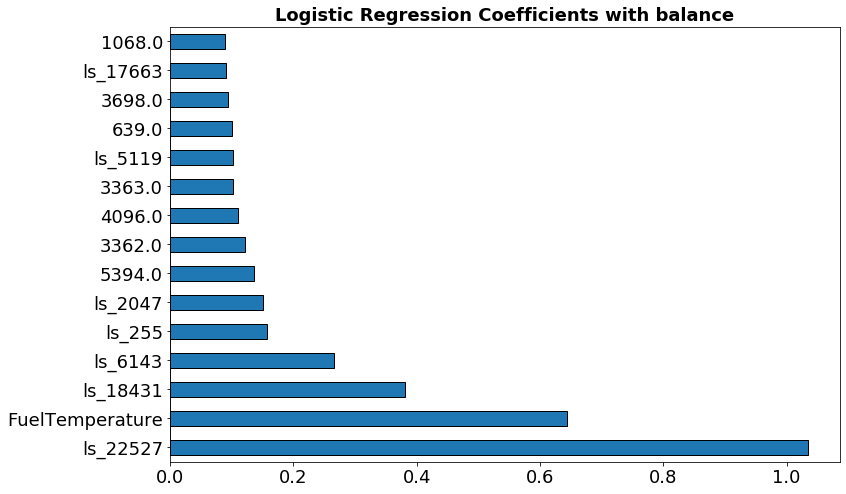

In [528]:
fig, ax = plt.subplots(figsize=(12, 8))
important_features.head(15).plot.barh(x = 'features', y = 'coefficients', ax = ax, edgecolor = 'black')
plt.vlines(x = 0, ymin = 0, ymax = 12)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('')
plt.title('Logistic Regression Coefficients with balance', fontweight = 'bold', fontsize = 18)
ax.get_legend().remove();

## Random Forest

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import GridSearchCV

In [181]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [182]:
grid_search = GridSearchCV(rf(),param_grid = {'max_depth':[20,25,30]})
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [183]:
depth = grid_search.best_params_['max_depth']
gs=grid_search.fit(X_train,y_train,max_depth = depth)

In [184]:
depth##15

30

# Using Pipeline

In [187]:
pipe = Pipeline([
    ('classifier',rf())])

params = dict(classifier__max_depth=[20,30,40])

grid_search = GridSearchCV(pipe,param_grid = params)
gs = grid_search.fit(X_train,y_train).best_params_

In [188]:
gs

{'classifier__max_depth': 30}

In [141]:
#save the clf(classifier) to file
with open('data/randomForest_model.pkl','wb') as file:
    pickle.dump(gs,file=file)

In [189]:
r = rf(max_depth = 30)

In [190]:
r.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [191]:
y_pred = r.predict(X_test)
y_probs =r.predict_proba(X_test)[:,1]

In [192]:
r.score(X_train,y_train)

1.0

In [193]:
from sklearn.metrics import roc_auc_score

In [194]:
roc_value = roc_auc_score(y_test,y_probs)

In [195]:
roc_value

0.9968049110953754

In [196]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': r.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
coefficients = fi.head(15)

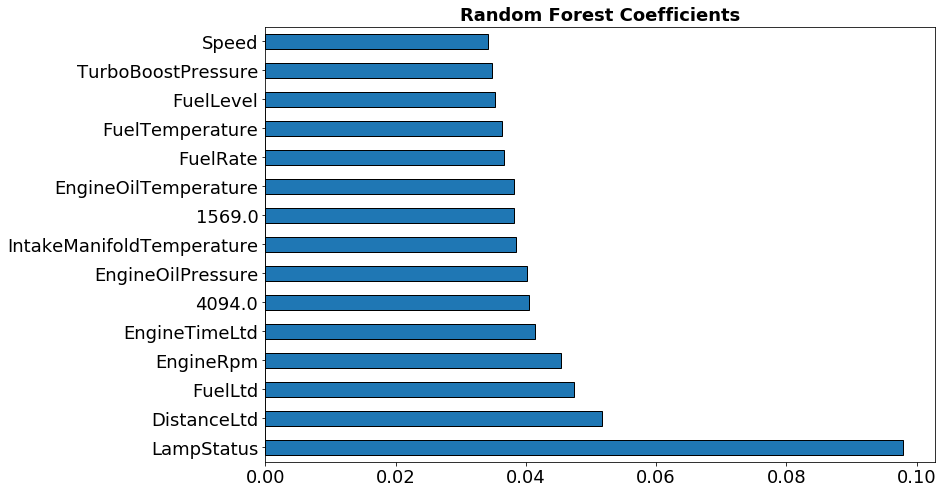

In [160]:
#old
fig, ax = plt.subplots(figsize=(12, 8))
coefficients.plot.barh(x = 'feature', y = 'importance', ax = ax, edgecolor = 'black')
plt.vlines(x = 0, ymin = 0, ymax = 12)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('')
plt.title('Random Forest Coefficients', fontweight = 'bold', fontsize = 18)
ax.get_legend().remove();

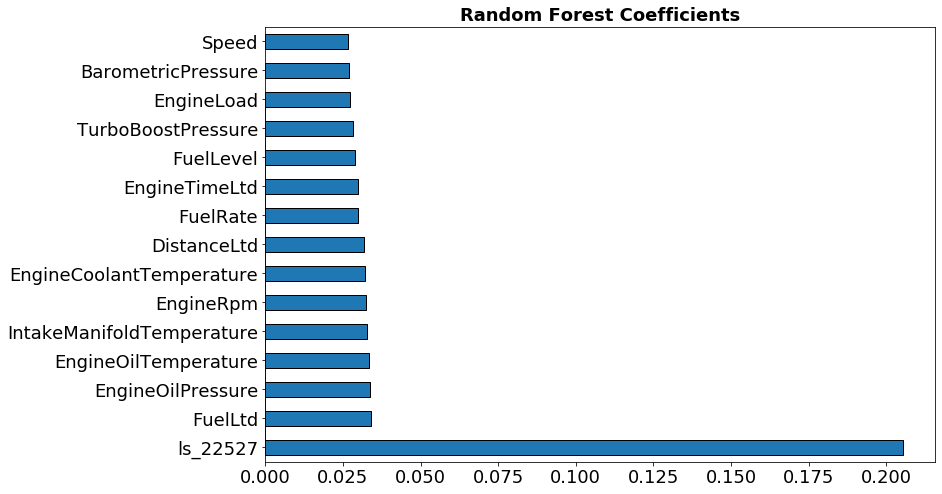

In [197]:
#New
fig, ax = plt.subplots(figsize=(12, 8))
coefficients.plot.barh(x = 'feature', y = 'importance', ax = ax, edgecolor = 'black')
plt.vlines(x = 0, ymin = 0, ymax = 12)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('')
plt.title('Random Forest Coefficients', fontweight = 'bold', fontsize = 18)
ax.get_legend().remove();

In [184]:
df.head(40)

,index,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,Dates,Hours
0,0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,111,17,1,2,1439,38.857638,-84.626851,1,0.000000,14.210000,1,66.486720,423178.70000,100.40000,11.00000,0.000000,96.743750,0.000000,1632.200000,43.200000,1.230091e+04,0.000000,36.901025,1,78.800000,1023,1,9199.322087,0.000000,3276.750000,70.11936,0.000000,2015-02-21,10:47:13
1,1,2,990360,2015-02-21 11:34:34,MissingDesc,unknown,629,12,1,127,1439,38.857638,-84.626851,2,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:34:34
3,3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,1807,2,1,127,1369,41.421018,-87.767361,4,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:35:33
5,5,6,990431,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,CMMNS,111,17,1,1,1417,33.043564,-96.179722,6,48.000000,14.427500,1,64.622600,470381.40000,181.40000,30.00000,38.280000,196.531300,1514.500000,9480.000000,44.000000,7.034981e+04,4.583399,36.901025,1,111.200000,1023,1,9199.322087,13.602200,3276.750000,70.11936,6.670000,2015-02-21,11:40:22
6,6,7,990439,2015-02-21 11:40:52,Low (Severity Low) Engine Coolant Level,unknown,111,17,1,2,1597,36.902916,-86.436481,7,82.800000,14.282500,1,64.622600,278736.70000,188.60000,80.00000,39.440000,210.031300,1711.375000,6292.200000,64.800000,4.096107e+04,14.291750,36.901025,1,78.800000,1023,1,9199.322087,41.534780,3276.750000,70.11936,20.590000,2015-02-21,11:40:52
7,7,8,990441,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,CMMNS,111,17,1,1,1429,38.228796,-84.582500,8,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1023,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:40:22
8,8,9,990442,2015-02-21 11:40:22,High (Severity Low) Water In Fuel Indicator,CMMNS,97,15,1,1,1429,38.228796,-84.582500,9,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1023,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:40:22
10,10,11,990459,2015-02-21 11:42:19,Low (Severity Low) Engine Coolant Level,CMMNS,111,17,1,1,1582,40.158055,-80.151018,11,28.032165,14.137500,1,64.622600,257885.90000,181.40000,80.00000,34.220000,218.975000,1382.375000,5085.350000,42.800000,3.772496e+04,13.723780,36.901025,1,78.800000,1023,1,9199.322087,64.826490,3276.750000,70.11936,17.690000,2015-02-21,11:42:19
14,14,15,990494,2015-02-21 11:14:38,Incorrect Data Brake Signal Sensor 1,unknown,1067,2,1,127,309,36.181898,-86.695046,15,0.000000,14.355000,1,66.486720,65022.28000,181.40000,0.00000,41.760000,193.831300,1369.875000,1308.900000,51.600000,9.487343e+03,0.000000,32.000000,1,100.400000,1279,1,9199.322087,26.311190,3276.750000,0.00000,0.580000,2015-02-21,11:14:38
16,16,17,990504,2015-02-21 11:45:14,Low (Severity Low) Engine Coolant Level,CMMNS,111,17,1,1,1601,38.279629,-78.935509,17,37.200000,14.137500,1,66.486720,268575.90000,183.20000,26.00000,33.640000,217.287500,1035.500000,5004.750000,66.000000,3.945013e

##Logistic regression only on fault codes

In [529]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

In [199]:
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.33, random_state=42)

In [530]:
from imblearn.over_sampling import RandomOverSampler

remove_from_X = ['EquipmentID','Dates',-99,4094,1569]# Remove 1569
y=bigGExpress_final[-99]
X=bigGExpress_final.drop(remove_from_X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y,stratify = y, test_size=0.33, random_state=42)



In [ ]:
oversampler = RandomOverSampler(random_state = 321)

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
y_resampled.value_counts()

lr = LogisticRegression(penalty ='l1',C=10,solver = 'saga',max_iter=100)
lr.fit(X_resampled,y_resampled)

y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [201]:
bigGExpress.head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,Dates,Hours,ls_0,ls_2,ls_9,ls_11,ls_255,ls_511,ls_544,ls_617,ls_1023,ls_1279,ls_2035,...,17590.0,25780.0,29902.0,32000.0,32894.0,35527.0,36017.0,37265.0,39093.0,42190.0,43088.0,46262.0,47284.0,50353.0,51923.0,53958.0,54478.0,56503.0,65287.0,65302.0,65303.0,65535.0,76339.0,78132.0,88121.0,114863.0,139296.0,153931.0,196608.0,335040.0,520200.0,520201.0,520203.0,520271.0,520273.0,520274.0,520298.0,520302.0,520321.0,520330.0,520413.0,520953.0,521032.0,523530.0,523531.0,523543.0,524033.0,524037.0,524071.0,524287.0
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,111,17,1,2,1439,38.857638,-84.626851,1,0.000000,14.210000,1,66.486720,423178.70000,100.40000,11.00000,0.000000,96.743750,0.000000,1632.200000,43.200000,1.230091e+04,0.000000,36.901025,1,78.800000,1023,1,9199.322087,0.000000,3276.750000,70.11936,0.000000,2015-02-21,10:47:13,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,990360,2015-02-21 11:34:34,MissingDesc,unknown,629,12,1,127,1439,38.857638,-84.626851,2,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:34:34,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,363,994985,2015-02-21 16:45:31,MissingDesc,unknown,629,12,1,127,1439,36.975462,-84.106666,363,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,16:45:31,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,403,995677,2015-02-21 17:54:42,MissingDesc,unknown,629,12,1,127,1439,36.975509,-84.106759,403,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,17:54:42,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,1807,2,1,127,1369,41.421018,-87.767361,4,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,1279,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-02-21,11:35:33,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [211]:
bigGExpress_final.columns.get_loc('ls_65535')

59

In [531]:
only_faults=bigGExpress_final.iloc[:,60:]

In [533]:
only_faults

,-99.0,0.0,16.0,27.0,33.0,37.0,38.0,51.0,70.0,74.0,75.0,77.0,78.0,81.0,84.0,91.0,92.0,94.0,95.0,96.0,97.0,98.0,100.0,101.0,102.0,103.0,105.0,107.0,108.0,110.0,111.0,116.0,118.0,125.0,127.0,153.0,157.0,158.0,160.0,167.0,168.0,171.0,173.0,174.0,175.0,177.0,184.0,188.0,190.0,191.0,...,17590.0,25780.0,29902.0,32000.0,32894.0,35527.0,36017.0,37265.0,39093.0,42190.0,43088.0,46262.0,47284.0,50353.0,51923.0,53958.0,54478.0,56503.0,65287.0,65302.0,65303.0,65535.0,76339.0,78132.0,88121.0,114863.0,139296.0,153931.0,196608.0,335040.0,520200.0,520201.0,520203.0,520271.0,520273.0,520274.0,520298.0,520302.0,520321.0,520330.0,520413.0,520953.0,521032.0,523530.0,523531.0,523543.0,524033.0,524037.0,524071.0,524287.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Only on faults

In [536]:
remove_from_X = [-99,4094,1569]#remove 4094 and 1569
y=only_faults[-99]
X=only_faults.drop(remove_from_X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.33, random_state=42)

oversampler = RandomOverSampler(random_state = 321)

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
y_resampled.value_counts()

lr = LogisticRegression(penalty ='l1',C=10,solver = 'saga',max_iter=100)
lr.fit(X_resampled,y_resampled)



/Users/sbussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [537]:
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[42825  2737]
 [    8   106]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     45562
         1.0       0.04      0.93      0.07       114

    accuracy                           0.94     45676
   macro avg       0.52      0.93      0.52     45676
weighted avg       1.00      0.94      0.97     45676



In [538]:
#find important features only for faults

df_columns=X.columns.values
important_features=pd.concat([pd.DataFrame(df_columns), pd.DataFrame(lr.coef_[0])], axis=1)
important_features.columns = ['features','coefficients']
important_features=important_features.sort_values(by= 'coefficients',ascending = False)
important_features

,features,coefficients
317,5394,0.199470
234,3362,0.199392
183,1347,0.176517
273,4342,0.169544
265,4096,0.146846
259,3698,0.129919
214,3031,0.126575
282,4375,0.117898
236,3364,0.114390
333,5742,0.102867


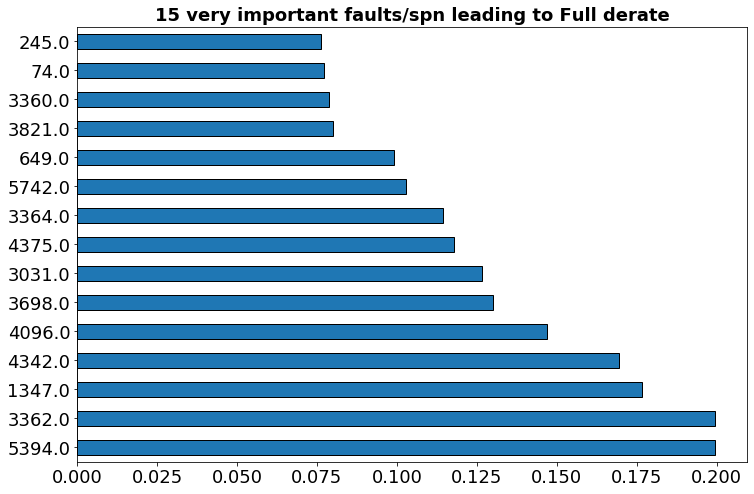

In [545]:
fig, ax = plt.subplots(figsize=(12, 8))
important_features.head(15).plot.barh(x = 'features', y = 'coefficients', ax = ax, edgecolor = 'black')
plt.vlines(x = 0, ymin = 0, ymax = 12)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('')
plt.title('15 very important faults/spn leading to Full derate', fontweight = 'bold', fontsize = 18)
ax.get_legend().remove();

In [343]:
def my_scorer(y_test,y_est,cost_fp = int(100),cost_fn=int(4000)):
    tn,fp,fn,tp = confusion_matrix(y_test,y_est).ravel()
    return  cost_fn*tp - cost_fp*fp 

In [335]:
confusion_matrix(y_test,y_pred).ravel()

array([44559,   990,     6,   121])

In [342]:
(4000 * 121) - (990 * 100)

385000

In [344]:
print(my_scorer(y_test, y_pred))

385000


In [348]:
df.EventTimeStamp.min(),df.EventTimeStamp.max()

(Timestamp('2000-03-18 19:14:10'), Timestamp('2020-03-06 14:14:13'))

In [546]:
d_rate.EventTimeStamp.min(),d_rate.EventTimeStamp.max()

(Timestamp('2011-01-01 00:03:22'), Timestamp('2020-02-14 11:21:54'))

In [547]:
d_rate['year']= pd.to_datetime(d_rate['EventTimeStamp'], format='%Y:%M:%D').dt.year


In [548]:
d_rates_by_year = d_rate.groupby('year')['RecordID'].count().reset_index()

In [549]:
d_rates_by_year.columns = ['Year','Num. Of Derates']

In [550]:
d_rates_by_year['num. or derates@95%'] = d_rates_by_year['Num. Of Derates'] * 95/100

In [551]:
d_rates_by_year['Savings@95%'] = (d_rates_by_year['Num. Of Derates']*95/100) * 4000

In [ ]:
d_rates_by_year

Text(0.5, 1.0, 'Number of  Derates by Year')

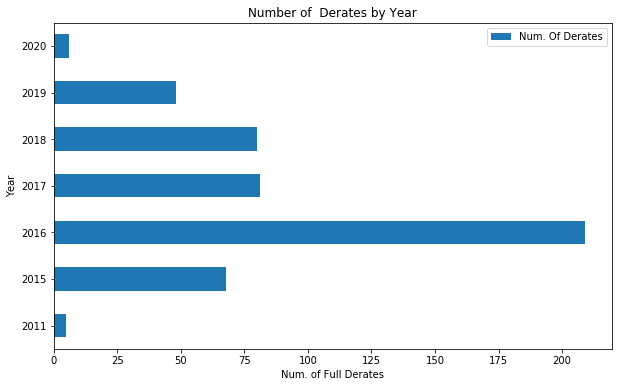

In [410]:
fig, ax = plt.subplots(figsize=(10, 6))
d_rates_by_year.plot(kind= 'barh', x = 'Year',y='Num. Of Derates',ax = ax)
plt.xlabel('Num. of Full Derates')
plt.title('Number of  Derates by Year')

In [553]:
df[df['spn']==5394]

,index,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,Dates,Hours,ls_0,ls_2,ls_9,ls_11,ls_255,ls_511,ls_544,ls_617,ls_1023,ls_1279,ls_2035,ls_2047,ls_4351,ls_5119,ls_5375,ls_6143,ls_11801,ls_16639,ls_16895,ls_17407,ls_17663,ls_18419,ls_18431,ls_20735,ls_21503,ls_22515,ls_22527,ls_28436,ls_50175,ls_50431,ls_51199,ls_55295,ls_62463,ls_63487,ls_65535
17409,17409,18292,1821480,2015-04-10 13:46:33,MissingDesc,CMMNS,5394,4,1,1,1465,39.330231,-84.446157,18292,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,17407,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-04-10,13:46:33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23253,23253,24136,1922004,2015-04-16 10:52:30,MissingDesc,VOLVO,5394,12,1,1,1671,38.335324,-85.754861,24136,28.032165,17.216151,1,61.212678,361935.77362,169.98012,31.52867,33.314296,236.645271,979.945308,7205.398517,61.008295,7.733250e+08,96.746862,36.901025,1,106.700633,16639,1,9199.322087,135.496253,3024.362454,70.11936,6.181061,2015-04-16,10:52:30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45778,45778,46890,2321753,2015-05-08 08:50:45,MissingDesc,CMMNS,5394,5,1,1,1396,36.944583,-80.956296,46890,28.032165,13.702500,1,66.486720,467215.10000,188.60000,61.00000,35.380000,208.906300,1283.500000,9104.650000,59.200000,7.026263e+04,11.597190,36.901025,1,96.800000,17407,1,9199.322087,60.117660,3276.750000,70.11936,12.760000,2015-05-08,08:50:45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51051,51051,52163,2416048,2015-05-13 20:18:04,MissingDesc,CMMNS,5394,5,1,1,1396,34.118611,-84.742870,52163,28.032165,14.355000,1,66.486720,468950.30000,195.80000,42.00000,19.140000,210.425000,794.250000,9139.450000,46.800000,7.052218e+04,4.239975,36.901025,1,109.400000,17407,1,9199.322087,2.466067,3276.750000,70.11936,7.830000,2015-05-13,20:18:04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52641,52641,54711,2443777,2015-05-15 07:18:22,MissingDesc,CMMNS,5394,5,1,1,1396,34.271851,-84.808287,54711,28.032165,14.427500,1,66.486720,469307.30000,147.20000,51.00000,31.900000,140.787500,600.750000,9149.300000,34.800000,7.057594e+04,3.394622,36.901025,1,93.200000,17407,1,9199.322087,0.427193,3276.750000,70.11936,3.480000,2015-05-15,07:18:22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60911,60911,62981,2574542,2015-05-22 13:21:38,MissingDesc,CMMNS,5394,7,1,1,105393153,34.718194,-86.634259,62981,60.800000,14.427500,1,66.486720,471061.30000,188.60000,51.00000,34.220000,215.262500,1346.500000,9188.650000,67.200000,7.086310e+04,8.440324,36.901025,1,111.200000,17407,1,9199.322087,63.282770,3276.750000,70.11936,11.600000,2015-05-22,13:21:38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67403,67403,69473,2671238,2015-05-29 02:50:51,MissingDesc,CMMNS,5394,4,1,1,105393153,36.607268,-86.540416,69473,64.400000,14.355000,1,44.117360,473297.80000,190.40000,58.00000,38.860000,177.462500,1388.125000,9231.400000,60.400000,7.117006e+04,9.681936,36.901025,1,107.600000,17407,1,9199.322087,47.447520,3276.750000,70.11936,15.370000,2015-05-29,02:50:51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67681,67681,69751,2676151,2015-05-29 08:44:54,MissingDesc,CMMNS,5394,7,1,1,105393153,36.098888,-86.677083,69751,85.200000,14.500000,1,66.486720,473376.40000,188.60000,85.00000,34.800000,202.775000,1245.875000,9233.500000,90.400000,7.118023e+0